In [1]:
# Primary Libraries
import ast
import re
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import dataframe_image as dfi

# http://shakedzy.xyz/dython/modules/nominal/
from dython.nominal import associations
import scipy.stats as ss

# Libraries for ML Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA

# Libraries for Binary Classification
import category_encoders as ce
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score, LearningCurveDisplay
from sklearn.metrics import classification_report, make_scorer, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier

# Libraries for Recommender System
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Libraries for Customer Segmentation
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, silhouette_visualizer
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator

import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 300)
sns.set_theme(style="whitegrid", palette="pastel")

C:\Users\idben\anaconda3\envs\oldBase\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Project Structure:**
<ul>
<li>03.01: Introduction</li>
<li>03.02: Preprocessing</li>
<li>03.03: Creating benchmark classifier models</li>
    
<li>03.04: Fine-tuning the benchmark classifier models
<ul>
<li>03.04A: Tuning Logistic Regression Model</li>
<li>03.04B: Tuning KNeighbors Model</li>
<li>03.04C: Tuning Random Forest Classifier Model</li>
<li>03.04D: Tuning Gradient Boosting Classifier Model</li>
</ul>
</li>
<li>03.05: Creating Final classifier model</li>
<li>03.06: Monetary Value Performance of the Final Classifier Model</li>
</ul>

## 03: Binary Classification Model
Create a machine learning model to assist in selecting potential customers.

#### 03.01: Introduction

Assumptions:

- H0: Customers do not buy the insurance product.
- H1: Customers buy the insurance product.

False positives and false negatives play equally important roles in determining which customers are going to buy the insurance product.

Having more **false positives** means that more customers are assumed to buy the insurance product; however, in reality, none of them will buy the product, and the company has already spent marketing budget to try to acquire these customers. On the other hand, having more **false negatives** means that many customers are assumed not to buy the insurance product, while in reality, they are going to buy the product. Hence, potential revenues from these customers are lost.

Therefore, the metric to be used is the **'F1 score.'** The F1 score is the harmonic mean between precision and recall, giving equal attention to both false positives and false negatives. It is also a suitable metric to use in an imbalanced dataset.

**Dataset Description:**
1. 'Married_Insured': Column combined from 'Married' and 'Insurance Type' columns
2. 'Plan Code': Unique product code per insurance product
3. 'Policy Duration': Duration of active policy
4. 'Policy Type': Type of insurance policy (e.g there could be someone who buys an insurance policy only or an insurance policy plus a health rider)
5. 'Policy Category': Grouping category for the policy type (e.g. polis category A adalah polis tipe Health and Jiwa).
6. 'Premium Amount': The total amount of premiums we receive from insurance customers.
9. 'premium_lifetime': Total premium during the customer's tenure with us
10. 'impression': Overall customers impression (*based on past purchases from the 'prodScore' column*)

**Game plan:**
1. Preprocessing
2. Creating benchmark classifier models.
3. Fine-tuning the benchmark classifier models.
4. Creating Final classifier model

<hr>

**Notes:**
1. The **classifier models** that are going to be used are: 'Logistic Regression' (*linear model*), 'KNeighbors Classifier' (*Neighbors model*), 'Random Forest' (*ensemble model*), 'Gradient Boosting Classifier' (*ensemble model*)

**Notes for 'prodScore' column:**
Each product starts with a score of 0, then deducts 1.5 for the first response (the most recent response) of '0,' and deducts 1 for subsequent responses. It adds 1.5 for the first response (the most recent response) of '1' and adds 1 for subsequent responses.

#### 03.02: Preprocessing

In [2]:
# Establishing constants
RANDOM_STATE = 2023
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
SCORING = 'f1'

In [3]:
# Importing the dataset
df = pd.read_csv('data-cleaned.csv')
bcdf = df.copy()  # Creating binary classification DF
bcdf.drop(columns=['Unnamed: 0'], inplace=True)
bcdf['prodScore'] = bcdf['prodScore'].apply(ast.literal_eval)
bcdf.head()

,Customer ID,City Code,Accomodation Ownership,Age,Married_Insured,Plan Code,Policy Duration,Policy Type,Policy Category,Premium Amount,Response,customer_lifetime,isLoyal,premium_lifetime,purchase_frequency,prodScore,premium_LTYes,premium_LTNo,numProdTried,impression
0,81716,C2,Rented,75,2,X2,4.0,3,21,44689.0,0,0,0,92908.0,2,"{'X2': -1.5, 'X1': -1.5}",0.0,92908.0,2,-3.0
1,80492,C13,Owned,75,2,X1,6.0,3,18,15141.0,1,0,0,15141.0,1,{'X1': 1.5},15141.0,0.0,1,1.5
2,75895,C14,Owned,75,2,X2,1.0,3,8,33206.0,1,52,1,76905.0,2,{'X2': 0.5},33206.0,43699.0,1,0.5
3,85258,C4,Owned,75,2,X1,8.0,2,20,31657.0,0,50,1,98867.0,3,"{'X1': -1.5, 'X2': 0.5}",30585.0,68282.0,2,-1.0
4,80292,C3,Owned,75,2,X1,2.0,2,16,37167.0,0,0,0,37167.0,1,{'X1': -1.5},0.0,37167.0,1,-1.5


In [4]:
# These features are selected based on multiple Recursive Feature Elimination (RFE) runs and trial & errors
features = ['Married_Insured', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category', 'Premium Amount', 'premium_lifetime', 'impression']

bcdf1 = bcdf[features+['Response']]
y = bcdf1['Response'].copy()
X = bcdf1[features].copy()

# Changing Data types
X['Married_Insured'] = X['Married_Insured'].astype('str')
X['Policy Type'] = X['Policy Type'].astype('str')
X['Policy Category'] = X['Policy Category'].astype('str')


Xlist_num = X.select_dtypes(exclude='object').columns  # numerical features | 'Premium Amount', 'premium_lifetime', 'impression'
Xlist_stdScaler = ['Premium Amount', 'impression']  # Standard scaler | 'Premium Amount', 'impression'
Xlist_robScaler = ['premium_lifetime']  # Robust scaler | 'premium_lifetime'

Xlist_cat = X.select_dtypes(include='object').columns  # categorical features | 'Married_Insured', 'Plan Code', 'Policy Duration', 'Policy Type', 'Policy Category'
Xlist_ord = ['Policy Duration']  # ordinal encoding | 'Policy Duration'
Xlist_nom = [i for i in Xlist_cat if i not in Xlist_ord]  # oneHot encoding | 'Married_Insured', 'Plan Code', 'Policy Category', 'Policy Type'

# Rather than using the category encoders library for ordinal encoding, it is more efficient to change the data type of the 'Policy Duration' column to integer.
# But first, the variable '14+' needs to be changed to '15.0'.
X.loc[X['Policy Duration']=='14+', 'Policy Duration'] = '15.0'
X['Policy Duration'] = X['Policy Duration'].astype('str').astype('float').astype('int32')  # Changing to string type, then float, then int32
# 'Policy Duration' column has been manually ordinal-encoded
for i in np.sort(X['Policy Duration'].unique()):
    X.loc[X['Policy Duration']==i, 'Policy Duration'] = i-1
    
# Splitting the data into 'training-validation' and 'testing' sets
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.2)

In [5]:
# Creating a column transformer to transform the train-test dataset
trans = ColumnTransformer([
    ('stdScaler', StandardScaler(), Xlist_stdScaler),
    ('robScaler', RobustScaler(), Xlist_robScaler),
    ('NomEnc', OneHotEncoder(drop='first'), Xlist_nom)
])

In [6]:
# Transforming the train-test dataset
X_tr = trans.fit_transform(X)
X_train_tr = trans.fit_transform(X_train)
X_test_tr = trans.fit_transform(X_test)

#### 03.03: Creating benchmark classifier models

In [7]:
# Classifier models
logreg = LogisticRegression(random_state=RANDOM_STATE, n_jobs=2)
knc = KNeighborsClassifier(n_jobs=2)
rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=2)
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [8]:
# Creating model parameters
logreg_params = {'random_state': RANDOM_STATE, 'n_jobs':2}
knc_params = {'n_jobs':2}
rfc_params = {'random_state': RANDOM_STATE, 'n_jobs':2}
gbc_params = {'random_state': RANDOM_STATE}

# Creating list of classifier models
models = [
    ('logreg', LogisticRegression, logreg_params),
    ('knc', KNeighborsClassifier, knc_params),
    ('rfc', RandomForestClassifier, rfc_params),
    ('gbc', GradientBoostingClassifier, gbc_params)
]

In [9]:
bench_models_score = []

def cv_score(scoring, models):
    for name, algo, param in models:
        model = algo(**param)
        cv_score = cross_val_score(model, X_train_tr, y_train, cv=CV, scoring=scoring)
        cv_score_mean, cv_score_std = np.mean(cv_score), np.std(cv_score)
        print(f"Mean of {name}'s {scoring} cross validation score: {round(cv_score_mean,5)} - standard dev: {round(cv_score_std,5)}")
        bench_models_score.append((name, model, cv_score_mean, cv_score_std))

cv_score(SCORING, models)

Mean of logreg's f1 cross validation score: 0.86388 - standard dev: 0.01034
Mean of knc's f1 cross validation score: 0.8451 - standard dev: 0.00837
Mean of rfc's f1 cross validation score: 0.85884 - standard dev: 0.01057
Mean of gbc's f1 cross validation score: 0.8612 - standard dev: 0.009


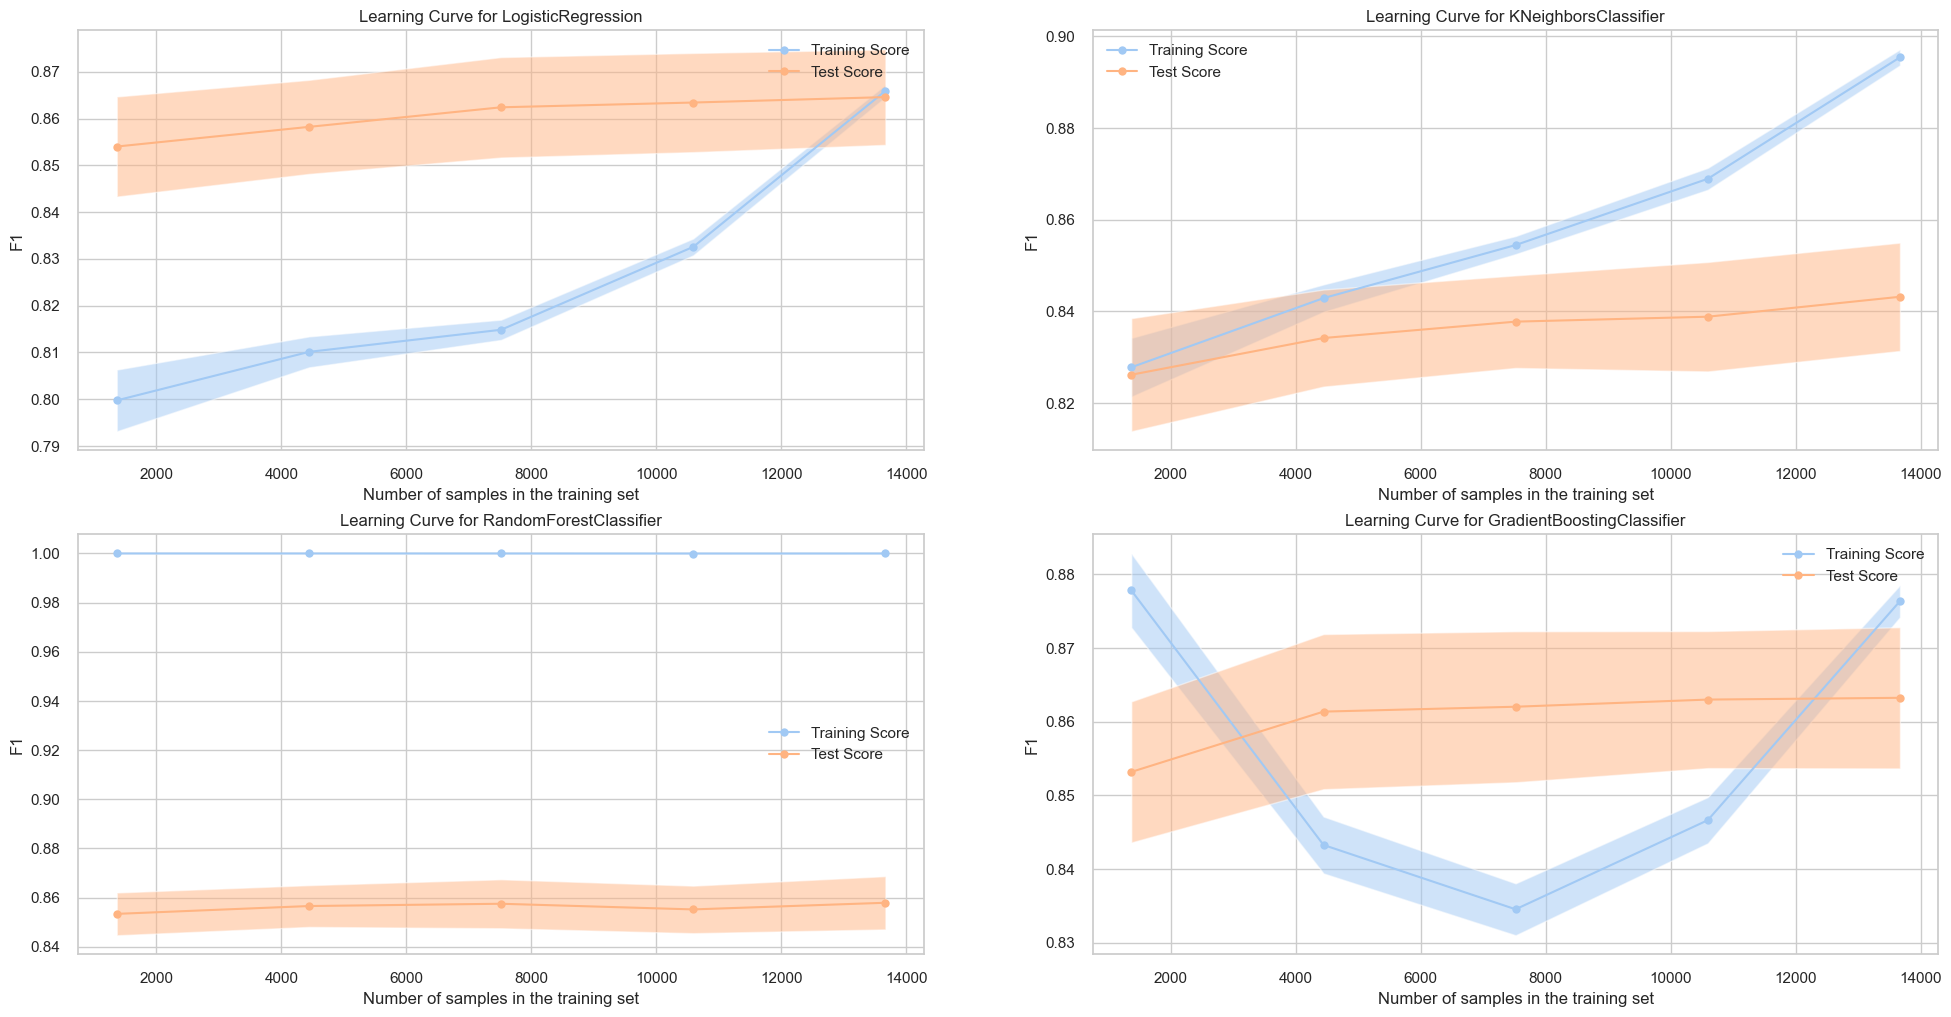

In [10]:
common_params = {
    "X": X_tr,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": CV,
    "score_type": "both",
    "n_jobs": 14,
    "line_kw": {"marker": "o"},
    "scoring": SCORING
}

plt.figure(figsize=(24, 12))
for idx, estimator in enumerate(bench_models_score):
    ax = plt.subplot(2,2,idx+1)
    LearningCurveDisplay.from_estimator(estimator[1], **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {estimator[1].__class__.__name__}")

The performance of the classifier models during the training and testing phases can be observed through the Learning Curve plots. These plots generally indicate that the testing phase performance of both the 'Logistic Regression' and the 'Gradient Boosting Classifier' models is superior to that of the training phase. Additionally, the 'KNeighbors Classifier' model exhibits moderately good performance, while the 'Random Forest Classifier' model appears to suffer from underfitting, although the testing set's performance remains reasonably good.

#### 03.04: Fine-tuning the benchmark classifier models

> 03.04A: Tuning Logistic Regression Model

In [11]:
# logreg_pipe.get_params()  # Checking the available parameters for tuning

In [12]:
# Logistic regression pipeline
startt = time()  # Start Time
logreg_pipe = Pipeline([
    ('trans', trans), 
    ('clf', logreg)
])

logreg_hparam = {
    'clf__C':[100, 10, 1, 0.1, 0.01, 0.001],
    'clf__penalty': ['l1', 'l2','elasticnet'],
    'clf__solver': ['liblinear', 'newton-cg']
}

logreg_gridSearch = GridSearchCV(
    logreg_pipe,
    param_grid=logreg_hparam,
    cv=CV,
    scoring=SCORING,
    n_jobs =14,
    verbose=1
)

logreg_gridSearch.fit(X_train, y_train)
endt = time()  # End Time
durationProcess = endt - startt  # Process Duration
print(f"Duration process takes: {round(durationProcess,2)} s")

Fitting 30 folds for each of 36 candidates, totalling 1080 fits
Duration process takes: 8.41 s


In [13]:
print(f"Logistic Regression Best Parameters: {logreg_gridSearch.best_params_}")
logreg_tuned_cv = cross_val_score(logreg_gridSearch.best_estimator_, X_train, y_train, cv=CV, scoring=SCORING)

Logistic Regression Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


In [14]:
# Creating a function to plot learning curve
def plot_learningCurve(model, model_name:str, score:str):
    common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": CV,
    "score_type": "both",
    "n_jobs": 14,
    "line_kw": {"marker": "o"},
    "scoring": score,
    }
    
    ax = plt.subplot(1,1,1)
    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {model_name}")
    plt.show()

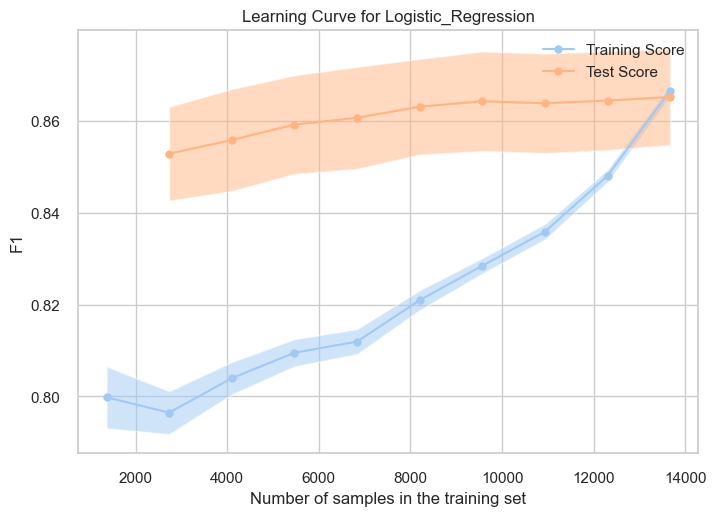

In [15]:
plot_learningCurve(logreg_gridSearch.best_estimator_, 'Logistic_Regression', SCORING)

In [16]:
print(f"The {bench_models_score[0][0]} benchmark model's F1 score cross validation score: {round(bench_models_score[0][2],5)}")
print(f"The {bench_models_score[0][0]} tuned model's F1 score cross validation score: {round(logreg_tuned_cv.mean(),5)}")

The logreg benchmark model's F1 score cross validation score: 0.86388
The logreg tuned model's F1 score cross validation score: 0.86497


**Findings:** The tuned version of the Logistic Regression model performs **slightly better** than the benchmark version, although the difference is insignificant.

In [17]:
logreg_gridSearch.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('stdScaler', StandardScaler(),
                                                  ['Premium Amount',
                                                   'impression']),
                                                 ('robScaler', RobustScaler(),
                                                  ['premium_lifetime']),
                                                 ('NomEnc',
                                                  OneHotEncoder(drop='first'),
                                                  ['Married_Insured',
                                                   'Plan Code', 'Policy Type',
                                                   'Policy Category'])])),
                ('clf',
                 LogisticRegression(C=10, n_jobs=2, random_state=2023,
                                    solver='liblinear'))])

In [18]:
# Creating list of tuned models
tuned_models_score = [
    ('logreg', logreg_gridSearch.best_estimator_, logreg_tuned_cv.mean())
]

> 03.04B: Tuning KNeighbors Model

In [19]:
# knc_pipe.get_params()  # Checking the available parameters for tuning

In [20]:
# KNC pipeline
startt = time()  # Start Time
knc_pipe = Pipeline([
    ('transformer', trans), 
    ('clf', knc)
])

knc_hparam = {
    'clf__n_neighbors':[3, 5, 7, 9, 11, 13, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['minkowski','euclidean','manhattan']
}

knc_gridSearch = GridSearchCV(
    knc_pipe,
    param_grid=knc_hparam,
    cv=CV,
    scoring=SCORING,
    n_jobs =14,
    verbose=1
)

knc_gridSearch.fit(X_train, y_train)
endt = time()  # End Time
durationProcess = endt - startt  # Process Duration
print(f"Duration process takes: {round(durationProcess,2)} s")

Fitting 30 folds for each of 42 candidates, totalling 1260 fits
Duration process takes: 74.68 s


In [21]:
print(f"KNC Best Parameters: {knc_gridSearch.best_params_}")
knc_tuned_cv = cross_val_score(knc_gridSearch.best_estimator_, X_train, y_train, cv=CV, scoring=SCORING)

KNC Best Parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 13, 'clf__weights': 'uniform'}


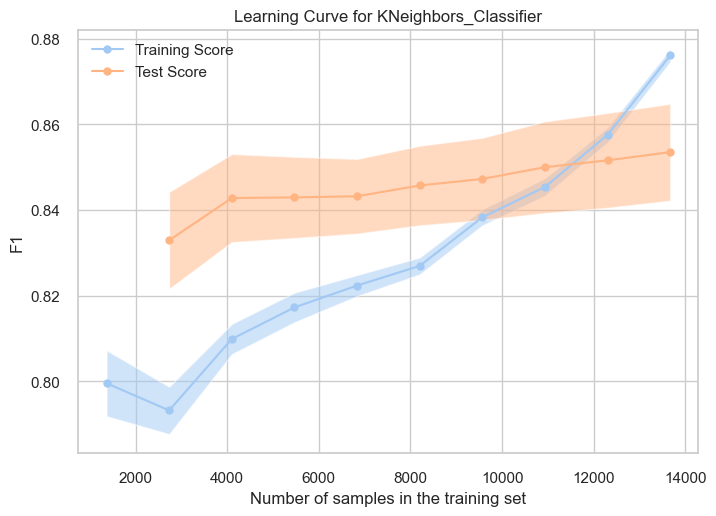

In [22]:
plot_learningCurve(knc_gridSearch.best_estimator_, 'KNeighbors_Classifier', SCORING)

In [23]:
print(f"The {bench_models_score[1][0]} benchmark model's F1 score cross validation score: {round(bench_models_score[1][2],5)}")
print(f"The {bench_models_score[1][0]} tuned model's F1 score cross validation score: {round(knc_tuned_cv.mean(),5)}")

The knc benchmark model's F1 score cross validation score: 0.8451
The knc tuned model's F1 score cross validation score: 0.8524


**Findings:** The tuned version of the KNeighbors Classifier model performs **slightly better** than the benchmark version.

In [24]:
tuned_models_score.append(('knc', knc_gridSearch.best_estimator_, knc_tuned_cv.mean()))

> 03.04C: Tuning Random Forest Classifier Model

In [25]:
# rfc_pipe.get_params()  # Checking the available parameters for tuning

In [26]:
# RFC pipeline
startt = time()  # Start Time
rfc_pipe = Pipeline([
    ('transformer', trans), 
    ('clf', rfc)
])

rfc_hparam = {
    'clf__max_depth': [int(i) for i in np.linspace(10,150, 5)],
    'clf__min_samples_split' : [2, 4],
    'clf__min_samples_leaf' : [1, 3],
    'clf__n_estimators' : [100, 300]
}

rfc_gridSearch = GridSearchCV(
    rfc_pipe,
    param_grid=rfc_hparam,
    cv=CV,
    scoring=SCORING,
    n_jobs =14,
    verbose=1
)

rfc_gridSearch.fit(X_train, y_train)
endt = time()  # End Time
durationProcess = endt - startt  # Process Duration
print(f"Duration process takes: {round(durationProcess,2)} s")

Fitting 30 folds for each of 40 candidates, totalling 1200 fits
Duration process takes: 502.73 s


In [27]:
print(f"RFC Best Parameters: {rfc_gridSearch.best_params_}")
rfc_tuned_cv = cross_val_score(rfc_gridSearch.best_estimator_, X_train, y_train, cv=CV, scoring=SCORING)

RFC Best Parameters: {'clf__max_depth': 45, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 300}


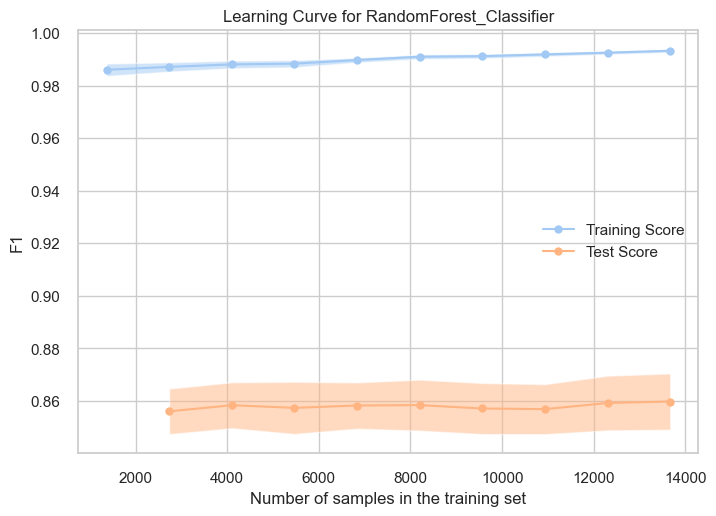

In [28]:
plot_learningCurve(rfc_gridSearch.best_estimator_, 'RandomForest_Classifier', SCORING)

In [29]:
print(f"The {bench_models_score[2][0]} benchmark model's precision cross validation score: {round(bench_models_score[2][2],5)}")
print(f"The {bench_models_score[2][0]} tuned model's precision cross validation score: {round(rfc_tuned_cv.mean(),5)}")

The rfc benchmark model's precision cross validation score: 0.85884
The rfc tuned model's precision cross validation score: 0.86017


**Findings:** The tuned version of the Random Forest Classifier model performs **slightly better** than the benchmark version.

In [30]:
tuned_models_score.append(('rfc', rfc_gridSearch.best_estimator_, rfc_tuned_cv.mean()))

> 03.04D: Tuning Gradient Boosting Classifier Model

In [31]:
# gbc_pipe.get_params()  # Checking the available parameters for tuning

In [32]:
# GBC pipeline
startt = time()  # Start Time
gbc_pipe = Pipeline([
    ('transformer', trans), 
    ('clf', gbc)
])

gbc_hparam = {
    'clf__max_depth': [2, 3, 5],
    'clf__min_samples_split' : [2, 4],
    'clf__min_samples_leaf' : [1, 3],
    'clf__n_estimators' : [100, 300]
}

gbc_gridSearch = GridSearchCV(
    gbc_pipe,
    param_grid=gbc_hparam,
    cv=CV,
    scoring=SCORING,
    n_jobs =14,
    verbose=1
)

gbc_gridSearch.fit(X_train, y_train)
endt = time()  # End Time
durationProcess = endt - startt  # Process Duration
print(f"Duration process takes: {round(durationProcess,2)} s")

Fitting 30 folds for each of 24 candidates, totalling 720 fits
Duration process takes: 271.27 s


In [33]:
print(f"GBC Best Parameters: {gbc_gridSearch.best_params_}")
gbc_tuned_cv = cross_val_score(gbc_gridSearch.best_estimator_, X_train, y_train, cv=CV, scoring=SCORING)

GBC Best Parameters: {'clf__max_depth': 3, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}


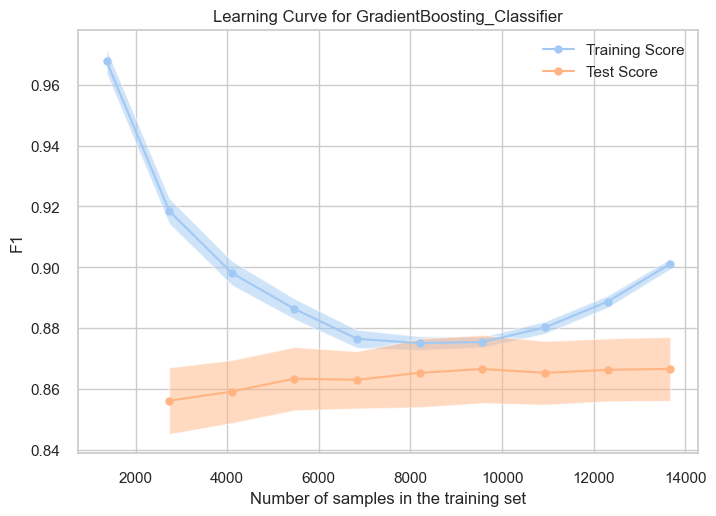

In [34]:
plot_learningCurve(gbc_gridSearch.best_estimator_, 'GradientBoosting_Classifier', SCORING)

In [35]:
print(f"The {bench_models_score[3][0]} benchmark model's precision cross validation score: {round(bench_models_score[3][2],5)}")
print(f"The {bench_models_score[3][0]} tuned model's precision cross validation score: {round(gbc_tuned_cv.mean(),5)}")

The gbc benchmark model's precision cross validation score: 0.8612
The gbc tuned model's precision cross validation score: 0.86623


**Findings:** The tuned version of the Gradient Boosting Classifier model performs **slightly better** than the benchmark version.

In [36]:
tuned_models_score.append(('gbc', gbc_gridSearch.best_estimator_, gbc_tuned_cv.mean()))

#### 03.05: Creating Final classifier model

In [37]:
# Combining tuned classifier models using voting classifier ('soft' voting)
vc = VotingClassifier([
    ('logreg', tuned_models_score[0][1]), 
    ('knc', tuned_models_score[1][1]),
    ('rfc', tuned_models_score[2][1]),
    ('gbc', tuned_models_score[3][1]),
], voting='soft')

In [38]:
vc_cv = cross_val_score(vc, X_train, y_train, cv=CV, scoring=SCORING)

In [39]:
print(f"During the training-validation phase, 'the final classifier model' has an averae F1 Score of {round(vc_cv.mean(), 5)} with standard dev of: {round(vc_cv.std(), 5)}")

During the training-validation phase, 'the final classifier model' has an averae F1 Score of 0.86514 with standard dev of: 0.00981


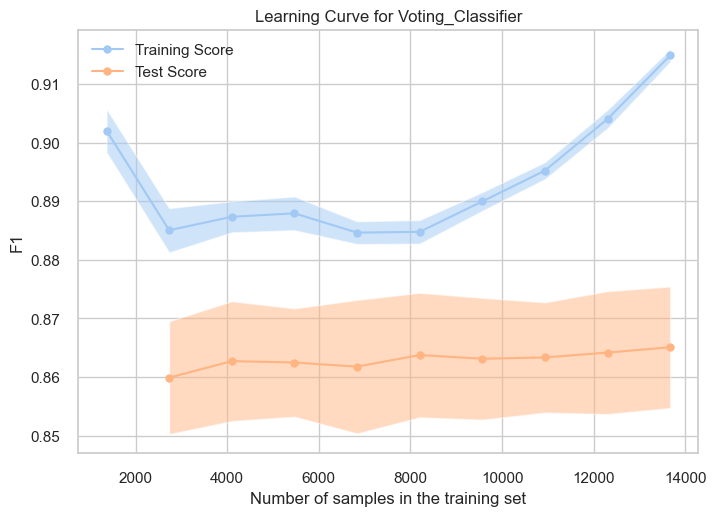

In [40]:
plot_learningCurve(vc, 'Voting_Classifier', SCORING)

In [41]:
vc.fit(X_train, y_train)  # Fitting the final model with training dataset

VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('trans',
                                               ColumnTransformer(transformers=[('stdScaler',
                                                                                StandardScaler(),
                                                                                ['Premium '
                                                                                 'Amount',
                                                                                 'impression']),
                                                                               ('robScaler',
                                                                                RobustScaler(),
                                                                                ['premium_lifetime']),
                                                                               ('NomEnc',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['Married_Insured',
                                                                                 'Plan '
                                                                                 'Code',
                                                                                 'Policy '
                                                                                 'Type',
                                                                                 'Policy '
                                                                                 'Category'])])),
                                              ('clf',
                                               LogisticRegression(C=10,...
                                               ColumnTransformer(transformers=[('stdScaler',
                                                                                StandardScaler(),
                                                                                ['Premium '
                                                                                 'Amount',
                                                                                 'impression']),
                                                                               ('robScaler',
                                                                                RobustScaler(),
                                                                                ['premium_lifetime']),
                                                                               ('NomEnc',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['Married_Insured',
                                                                                 'Plan '
                                                                                 'Code',
                                                                                 'Policy '
                                                                                 'Type',
                                                                                 'Policy '
                                                                                 'Category'])])),
                                              ('clf',
                                               GradientBoostingClassifier(min_samples_leaf=3,
                                                                          n_estimators=300,
                                                                          random_state=2023))]))],
                 voting='soft')

In [42]:
# Predicting the test dataset using pre-fitted final classifier model
y_pred = vc.predict(X_test)  # predicted result
y_pred_proba = vc.predict_proba(X_test)  # the probability of predicted result

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1930
           1       0.88      0.85      0.87      1108

    accuracy                           0.90      3038
   macro avg       0.90      0.89      0.90      3038
weighted avg       0.90      0.90      0.90      3038



The final classifier model has a **macro average F1-score of 0.90**

*Note: Macro Average --> all classes equally contribute to the final averaged metric*

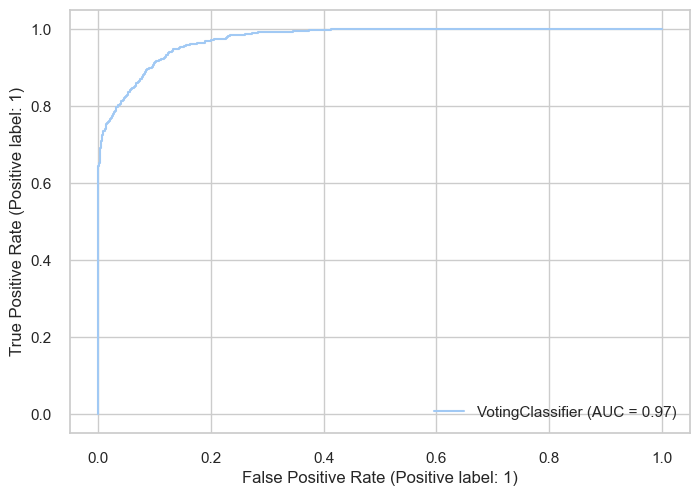

In [44]:
# The ROC AUC can be used to tune the threshold and improve the model, but in this case, I will not further adjust the final classifier
RocCurveDisplay.from_estimator(vc, X_test, y_test)

In [45]:
print(f"The Area under the curve (AUC) for this final classifier model: {round(roc_auc_score(y_test, y_pred_proba[:,1]),5)}")

The Area under the curve (AUC) for this final classifier model: 0.97424


#### 03.06: Monetary Value Performance of the Final Classifier Model

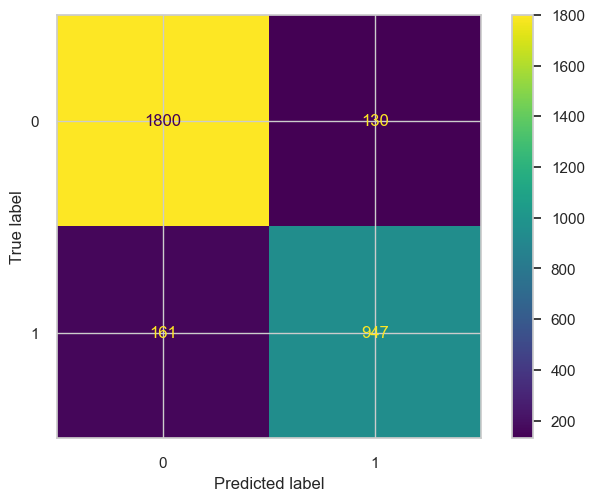

In [46]:
# Generating a confusion matrix for our final classifier model's performance
np.random.seed(RANDOM_STATE)
ConfusionMatrixDisplay.from_estimator(vc, X_test, y_test)
plt.show()

In [47]:
df_confu_final = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual_0', 'Actual_1'], columns=['Predicted_0', 'Predicted_1'])

In [48]:
print(f"This is the confusion matrix of the final classifier: \n{df_confu_final}")

This is the confusion matrix of the final classifier: 
          Predicted_0  Predicted_1
Actual_0         1800          130
Actual_1          161          947


In [49]:
# Generating a confusion matrix for a classifier model with no skill at all (random guessing)
confussionMatrix_noSkill = pd.DataFrame([[760, 759], [759, 760]], index=['Actual_0', 'Actual_1'], columns=['Predicted_0', 'Predicted_1'])
confussionMatrix_noSkill

,Predicted_0,Predicted_1
Actual_0,760,759
Actual_1,759,760


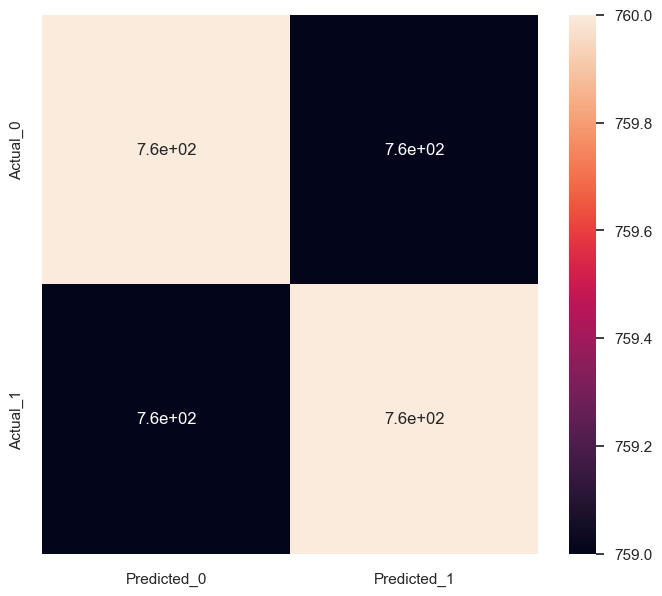

In [50]:
plt.figure(figsize=(8,7))
sns.heatmap(confussionMatrix_noSkill, annot=True)
plt.show()

In [51]:
# Calculating the performance of the no-skill classifier model
precision_NS = 760/(760+759)
recall_NS = 760/(760+759)
f1_NS = (2*precision_NS*recall_NS)/(precision_NS+recall_NS)
print(F"""
The No Skill model performance is: 
F1 Score: {round(f1_NS,5)}
Precision Score: {round(precision_NS, 5)}
Recall Score: {round(recall_NS, 5)}
""")


The No Skill model performance is: 
F1 Score: 0.50033
Precision Score: 0.50033
Recall Score: 0.50033



In [52]:
# Comparing the final classifier model's performance to that of the no-skill/random-guessing model
(confusion_matrix(y_test, y_pred)-confussionMatrix_noSkill)/confussionMatrix_noSkill

,Predicted_0,Predicted_1
Actual_0,1.368421,-0.828722
Actual_1,-0.787879,0.246053


**Findings:** 
The final classifier model can potentially increase revenue by 25% and decrease marketing sales expenses by 1.37 times compared to random guessing. Additionally, it successfully reduces the False Positive Rate by 83%, indicating an 83% reduction in the misallocation of the marketing and sales expense budget. Furthermore, the model manages to reduce potential revenue loss by 79%, as it lowers the False Negative Rate by 79%.

**Overall**, the final classifier model **reduces marketing and sales expenses by 220%** and **increases revenue by 103%** compared to the random-guessing model.

In [53]:
# Fitting the final classifier model with the entire dataset to make predictions for future, unseen data.
vc.fit(X, y)

VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('trans',
                                               ColumnTransformer(transformers=[('stdScaler',
                                                                                StandardScaler(),
                                                                                ['Premium '
                                                                                 'Amount',
                                                                                 'impression']),
                                                                               ('robScaler',
                                                                                RobustScaler(),
                                                                                ['premium_lifetime']),
                                                                               ('NomEnc',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['Married_Insured',
                                                                                 'Plan '
                                                                                 'Code',
                                                                                 'Policy '
                                                                                 'Type',
                                                                                 'Policy '
                                                                                 'Category'])])),
                                              ('clf',
                                               LogisticRegression(C=10,...
                                               ColumnTransformer(transformers=[('stdScaler',
                                                                                StandardScaler(),
                                                                                ['Premium '
                                                                                 'Amount',
                                                                                 'impression']),
                                                                               ('robScaler',
                                                                                RobustScaler(),
                                                                                ['premium_lifetime']),
                                                                               ('NomEnc',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['Married_Insured',
                                                                                 'Plan '
                                                                                 'Code',
                                                                                 'Policy '
                                                                                 'Type',
                                                                                 'Policy '
                                                                                 'Category'])])),
                                              ('clf',
                                               GradientBoostingClassifier(min_samples_leaf=3,
                                                                          n_estimators=300,
                                                                          random_state=2023))]))],
                 voting='soft')

In [54]:
# Saving the fitted-final classifier model using joblib
# joblib.dump(vc, 'BC_model')